# Creates a 1-year hourly electricity demand profile assuming full electrification of road transportation in Metro Vancouver in the year 2016    

For details on methods, assumptions, and data sources, refer to Chapter 5.6 in dissertation "How do we power decarbonization? Land and other resources in Canada’s West" http://hdl.handle.net/1828/11659

Note: daylight savings time and the February 29 have been removed from all data sources.

10 August 2021 Kevin Palmer-Wilson kevinpw@uvic.ca

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import datetime
from collections import OrderedDict #OrderedDict() allows us to create a legend wthout duplicate items
from os import getcwd, path

In [3]:
# Configuration:
input_path = path.join(getcwd(),'Input data')
output_path = path.join(getcwd(),'Output data')

In [4]:
#the file "Electricity demand scenario data.xlsx" contains annual energy demands and a compilation of observed efficiencies. 
#Assumed transformation efficciencies are also included. Let's read that file.
data = pd.read_excel(path.join(input_path,'Metro Vancouver Road Transport annual demands and efficiencies.xlsx'), sheet_name='Energy demands and efficiencies', skiprows=2)

#let's create a function to easily retrieve individual data points from this dataframe
def get(par, col='Applied Value', data=data):
    return data.at[data.index[data['Symbol']==par].tolist()[0],col]

## Annual Road Transportation Demand

In [5]:
#Total Road Transportation Energy Demand
E_T = (get('^E_PC')*get('n_PC,obs')/get('n_PC,trans')+
       get('^E_PT')*get('n_PT,obs')/get('n_PT,trans')+
       get('^E_FL')*get('n_FL,obs')/get('n_FL,trans')+
       get('^E_FMD')*get('n_FMD,obs')/get('n_FMD,trans')+
       get('^E_FMG')*get('n_FMG,obs')/get('n_FMG,trans')+
       get('^E_FH')*get('n_FH,obs')/get('n_FH,trans')     
      )

#Road Transportation Energy Demand by vehicle class
E_PC = get('^E_PC')*get('n_PC,obs')/get('n_PC,trans') #Passenger Cars
E_PT = get('^E_PT')*get('n_PT,obs')/get('n_PT,trans') #Passenger Trucks
E_FL = get('^E_FL')*get('n_FL,obs')/get('n_FL,trans') #Freight, Light-duty
E_FMD = get('^E_FMD')*get('n_FMD,obs')/get('n_FMD,trans') #Freight, Medium-duty, Diesel
E_FMG = get('^E_FMG')*get('n_FMG,obs')/get('n_FMG,trans') #Freight, Medium-duty, Gasoline
E_FH = get('^E_FH')*get('n_FH,obs')/get('n_FH,trans') #Freight, Heavy-duty

#compute the energy-weighted average efficiency
n_T_mean = (get('^E_PC')*get('n_PC,obs')+
             get('^E_PT')*get('n_PT,obs')+
             get('^E_FL')*get('n_FL,obs')+
             get('^E_FMD')*get('n_FMD,obs')+
             get('^E_FMG')*get('n_FMG,obs')+
             get('^E_FH')*get('n_FH,obs') 
            )/(get('^E_PC')*get('n_PC,obs')/get('n_PC,trans')+
               get('^E_PT')*get('n_PT,obs')/get('n_PT,trans')+
               get('^E_FL')*get('n_FL,obs')/get('n_FL,trans')+
               get('^E_FMD')*get('n_FMD,obs')/get('n_FMD,trans')+
               get('^E_FMG')*get('n_FMG,obs')/get('n_FMG,trans')+
               get('^E_FH')*get('n_FH,obs')/get('n_FH,trans')     
              )

print('Vancouver\'s annual electrified road transportations demand is')
print(round(E_T,2),' TWh')

print('Vancouver\'s energy-weighted mean electrified road transportation efficiency is')
print(round(n_T_mean,2),' km/kWh')

Vancouver's annual electrified road transportations demand is
14.42  TWh
Vancouver's energy-weighted mean electrified road transportation efficiency is
1.96  km/kWh


## Transportation Demand Profile

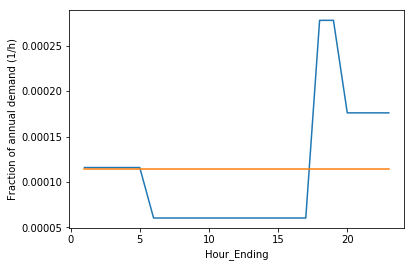

In [6]:
#Create a data frame with the dates and HE (hour ending) to store our transportation demand.
P_T = pd.read_excel(path.join(input_path,'DateAndHourEndingTemplate.xlsx'), sheet_name='2016_wout_Feb29_wout_DaylightST')

P_T = P_T.reset_index(drop=True)

#lets create a datetime column
P_T['Datetime'] = pd.to_datetime(P_T['Date'].astype(str) + ' ' + (P_T['Hour_Ending'] -1).astype(str) + ':00')

#Create hourly profile values such that the sum of all values over the year equals 1
#UNIFORM scenario assumes that electric vehicles charge such that their electricity demand appears constant-rate throughout the year
#UNIFORM-Scenario
P_T['UNIFORM'] = 1/8760

#PEAK-Scenario
#PEAK scenario assumes that electric vehicles charge such that their electricity demand peaks in evening hours at 5 and 6 PM
# in accodrance with Keller et al. 2019: https://doi.org/10.1016/j.apenergy.2019.113536
#read the 24h demand profile
dfTemp=pd.read_csv(path.join(input_path,'Assumed EV demand profile BC_24h.csv'))

#repeat the 24h profile for all 365 days and normalize
dfTemp2 = pd.concat([dfTemp]*365, ignore_index=True)
dfTemp2['Normalized_Demand'] = dfTemp2 ['Demand'] / dfTemp2 ['Demand'].sum() 

#copy the normalized peak demand profile into our profile dataframe
P_T['PEAK']= dfTemp2['Normalized_Demand']

#Plot the transportation demand profiles as a fraction of annual demand
ax = sns.lineplot(x = P_T['Hour_Ending'][0:23], y = P_T['PEAK'][0:23], legend = 'full', ci = None)
ax2 = sns.lineplot(x = P_T['Hour_Ending'][0:23], y = P_T['UNIFORM'][0:23], legend = 'full', ci = None)
ylabel = plt.ylabel('Fraction of annual demand (1/h)')

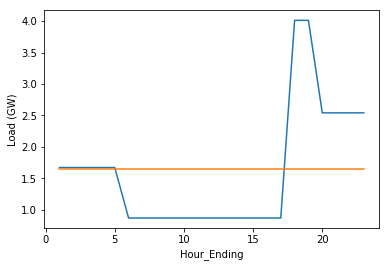

In [7]:
#Transportation Demand
#Plot the transportation demand as hourly load
ax = sns.lineplot(x = P_T['Hour_Ending'][0:23], y = P_T['PEAK'][0:23] * E_T * 1000, legend = 'full', ci = None)
ax2 = sns.lineplot(x = P_T['Hour_Ending'][0:23], y = P_T['UNIFORM'][0:23] * E_T * 1000, legend = 'full', ci = None)
ylabel = plt.ylabel('Load (GW)')

## Create a nicer plot of road transportation energy demands

In [8]:
#this function fixes duplpicate legend entries when we create legends for figures with subplots
#see stackoverflow for explanation: https://stackoverflow.com/questions/13588920/stop-matplotlib-repeating-labels-in-legend    
def fixDupesInLegend(figureHandle, legendOrder):
    #we need to cycle through all the axes and get all the handles so that we consider all Legend elements contained in any subplot
    #get all the axes contained in the figure
    axes = figureHandle.get_axes()
    #create an empty list of labels and handles
    label_list=[]
    handle_list=[]
    #cycle through the axes to get their labels and handles
    for i, ax in enumerate(axes):
        handles, labels = ax.get_legend_handles_labels()
        label_list.append(labels)
        handle_list.append(handles)
    #we need to flatten the label_list and the handles_list, because it is currently a list of lists (which we don't want)
    #see explanation on flattening: https://stackoverflow.com/questions/952914/making-a-flat-list-out-of-list-of-lists-in-python
    l = [item for sublist in label_list for item in sublist]
    h = [item for sublist in handle_list for item in sublist]
    by_label = dict(zip(l, h))
    #sort the dictionary, based on the legendOrder
    #see https://stackoverflow.com/questions/21773866/how-to-sort-a-dictionary-based-on-a-list-in-python
    by_label_sorted = OrderedDict(sorted(by_label.items(), key=lambda pair: legendOrder.index(pair[0])))
    #reverse the order of the legend entries when returning, so that solar is on the top
    return reversed(by_label_sorted.values()), reversed(by_label_sorted.keys())

#this function sets the title above a figure column
def setTitle(ax, row, title):
    #only set the title in the top row
    if row==0:
        ax.set(title=title)

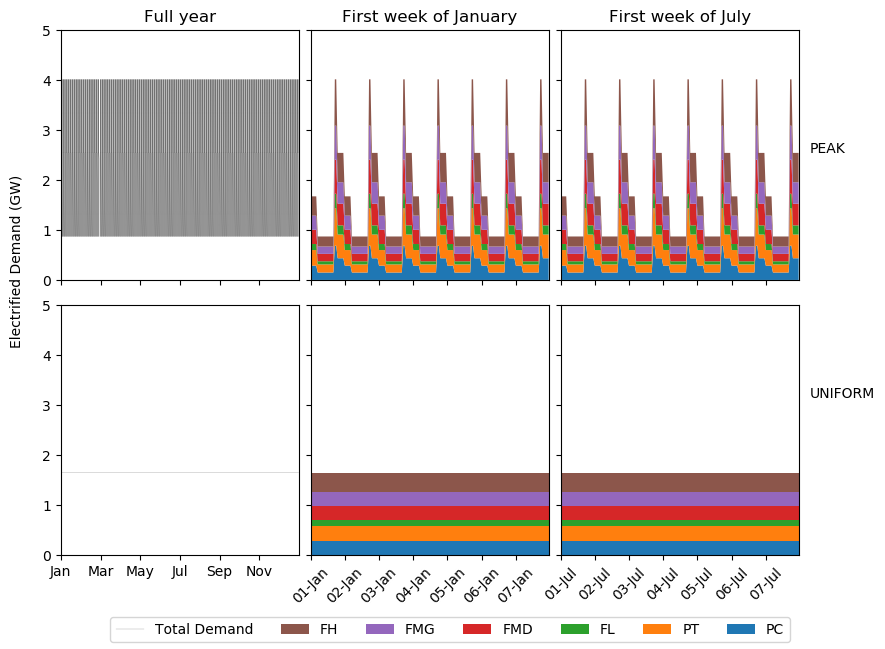

In [9]:
#plot the profiles
#some configuration
scenarios = ['PEAK', 'UNIFORM']

figsize=(10,7)
ylims = (0,5)
y_text = 'Electrified Demand (GW)'
tcklbls = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=figsize, dpi=100, sharex='col', sharey=True, squeeze=True)

##################################### 
#FIRST COLUMN: full years
##################################### 
for i, scn in enumerate(scenarios):
    axs[i][0].plot(P_T['Datetime'], P_T[scn]*E_T*1000, linewidth=0.10, color='black', label='Total Demand')
    
    #set labels
    axs[i][0].set_ylabel('')
    axs[i][0].set_xlabel('')
    axs[i][0].set_ylim(ylims)
    axs[i][0].set_xlim(P_T.at[0,'Datetime'],P_T.at[8759,'Datetime'])
      
    #correct xtick label placement
    locs = [matplotlib.dates.date2num(i) for i in P_T['Datetime'][::1460]]
    #format labels to display month as three-letter abbreviation
    labels = [ i.strftime("%b") for i in P_T['Datetime'][::1460] ]

    # Now set the ticks and labels
    axs[i][0].set_xticks(locs)
    axs[i][0].set_xticklabels(labels)
    
    #set custom y ticks
    ylim = axs[i][0].get_ylim()
    
    #set the title above the column
    setTitle(ax=axs[i][0], row=i, title='Full year')


#####################################    
#SECOND COLUMN: First week in January
##################################### 
for i, scn in enumerate(scenarios):
    #plot energy demand for each vehicle class
    axs[i][1].stackplot(P_T['Datetime'][0:168].values, 
                 P_T[scenarios[i]][0:168].values * E_PC*1000,
                 P_T[scenarios[i]][0:168].values * E_PT*1000,
                 P_T[scenarios[i]][0:168].values * E_FL*1000,
                 P_T[scenarios[i]][0:168].values * E_FMD*1000,
                 P_T[scenarios[i]][0:168].values * E_FMG*1000,
                 P_T[scenarios[i]][0:168].values * E_FH*1000,
                 labels=['PC','PT','FL','FMD','FMG','FH'],
                 linewidth=0
                )
    
    #set labels
    axs[i][1].set_ylabel('')
    axs[i][1].set_xlabel('')
    axs[i][1].set_ylim(ylims)
    axs[i][1].set_xlim(P_T.at[0,'Datetime'],P_T.at[167,'Datetime'])
    
    #correct xtick label placement
    locs = [matplotlib.dates.date2num(i) for i in P_T['Datetime'][0:168:24]]
    #format labels to display month as three-letter abbreviation
    labels = [ i.strftime("%d-%b") for i in P_T['Datetime'][0:168:24] ]

    # Now set the ticks and labels
    axs[i][1].set_xticks(locs)
    axs[i][1].set_xticklabels(labels, rotation=45)
    
    #set the title above the column
    setTitle(ax=axs[i][1], row=i, title='First week of January')
    
#####################################    
#THIRD COLUMN: First week in July
##################################### 
for i, scn in enumerate(scenarios):
    #plot energy demand for each vehicle class
    axs[i][2].stackplot(P_T['Datetime'][4344:4512].values,
                 P_T[scenarios[i]][4344:4512].values * E_PC*1000,
                 P_T[scenarios[i]][4344:4512].values * E_PT*1000,
                 P_T[scenarios[i]][4344:4512].values * E_FL*1000,
                 P_T[scenarios[i]][4344:4512].values * E_FMD*1000,
                 P_T[scenarios[i]][4344:4512].values * E_FMG*1000,
                 P_T[scenarios[i]][4344:4512].values * E_FH*1000,
                 labels=['PC','PT','FL','FMD','FMG','FH'],
                 linewidth=0
                )

    #set labels
    axs[i][2].set_ylabel('')
    axs[i][2].set_xlabel('')
    axs[i][2].set_ylim(ylims)
    axs[i][2].set_xlim(P_T.at[4344,'Datetime'],P_T.at[4511,'Datetime'])
    
    #correct xtick label placement
    locs = [matplotlib.dates.date2num(i) for i in P_T['Datetime'][4344:4512:24]]
    #format labels to display month as three-letter abbreviation
    labels = [ i.strftime("%d-%b") for i in P_T['Datetime'][4344:4512:24] ]

    # Now set the ticks and labels
    axs[i][2].set_xticks(locs)
    axs[i][2].set_xticklabels(labels, rotation=45)
    
    #set the title above the column
    setTitle(ax=axs[i][2], row=i, title='First week of July')
    
#####################################    
#Figure post-processing
##################################### 
    
#place y-label
fig.text(x=0.03, y=0.55, s=y_text, rotation=90, va='center', ha='left')

#place scenario labels to the right of the plots
for i, scn in enumerate(scenarios):
    fig.text(x=0.83, y=0.7/(i+1)-0.0, s=scn, rotation=0, va='bottom', ha='left', wrap=True)

#add a legend
legendOrder=['PC','PT','FL','FMD','FMG','FH', 'Total Demand']
lgd = fig.legend(*fixDupesInLegend(fig,legendOrder=legendOrder), loc='lower center', bbox_to_anchor=(0.45,0.0), frameon=True, ncol=7)

#calculate the appropriate width for the figure
#in units of 100 pixels, starting with wodth of legend on right + width of axis title on left + width of each of the 3 columns
width = 1.65 + 0.7 + 2.5 * 3 
#calculate how far left and right to put the plot borders within the image canvas (19.85*0.04 happens to be a nice factor)
left = (19.85/width) * 0.04
right = 1-((19.85/width) * (1-0.91))
plt.subplots_adjust(left=left, right=right, bottom=0.13, wspace=0.05, hspace=0.1)

#save the figure
fig.savefig(path.join(output_path,'transport-demand.jpg'), dpi=100, bbox_inches="tight")

# 6. Create csv file with hourly transportation energy demand

unit of columns: GW


In [10]:
#save to file called:
total_hourly_demand_file = 'Metra Vanvouver Road Transport hourly electrified demand.csv'

#convert the demands from TW to GW
for s in scenarios:
    P_T[s] = P_T[s] * E_T * 1000

#save the total hourly demands to a csv
P_T.to_csv(path.join(output_path,total_hourly_demand_file), index_label='Hour_Number')